In [19]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For loading models
import joblib
import lightgbm as lgb

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)


---
## Load Data and Models

In [20]:
# Load the dataset
df = pd.read_csv('../data/model_ready_data.csv')
df['Date'] = pd.to_datetime(df['Date'])

print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date Range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"\nCrops: {df['item'].unique().tolist()}")

Dataset Shape: 109,200 rows × 23 columns
Date Range: 2020-01-08 to 2024-12-31

Crops: ['Beetroot', 'Raddish', 'Red Onion', 'Rice']


In [21]:
# Load multi-horizon price forecasting models
model_dir = '../models/saved_models/multi_horizon'

# Load configuration
try:
    config = joblib.load(f'{model_dir}/config.joblib')
    print(f"  Horizons: {list(config['horizons'].keys())}")
    print(f"  Crops: {config['crops']}")
except:
    config = {
        'horizons': {'1_week': 7, '2_weeks': 14, '4_weeks': 28, '8_weeks': 56, '12_weeks': 84},
        'crops': ['Rice', 'Beetroot', 'Raddish', 'Red Onion']
    }

# Load LightGBM models
lgb_models = {}
for horizon in config['horizons'].keys():
    try:
        model = lgb.Booster(model_file=f'{model_dir}/lgb_{horizon}_model.txt')
        lgb_models[horizon] = model
    except:
        print(f"{horizon} model not found")

  Horizons: ['1_week', '2_weeks', '4_weeks', '8_weeks', '12_weeks']
  Crops: ['Beetroot', 'Raddish', 'Red Onion', 'Rice']


---
## Prepare Current Market Data

In [22]:
# Aggregate data by Date and Crop
df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.dayofweek
df['quarter'] = df['Date'].dt.quarter

agg_df = df.groupby(['Date', 'item']).agg({
    'price': 'mean',
    'volume_MT': 'mean',
    'temperature_avg_C': 'mean',
    'rainfall_mm': 'mean',
    'humidity_percent': 'mean',
    'month': 'first',
    'day_of_week': 'first',
    'quarter': 'first',
    'is_public_holiday': 'max',
    'is_day_before_holiday': 'max',
    'near_major_holiday': 'max',
    'demand_multiplier': 'mean',
    'harvest_period_rice': 'max',
    'vegetable_peak_season': 'max'
}).reset_index()

agg_df = agg_df.sort_values(['item', 'Date']).reset_index(drop=True)

# Add lag features
for lag in [1, 7, 14, 28]:
    agg_df[f'price_lag_{lag}'] = agg_df.groupby('item')['price'].shift(lag)
    agg_df[f'volume_lag_{lag}'] = agg_df.groupby('item')['volume_MT'].shift(lag)

# Rolling statistics
agg_df['price_rolling_7_mean'] = agg_df.groupby('item')['price'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean())
agg_df['price_rolling_7_std'] = agg_df.groupby('item')['price'].transform(
    lambda x: x.rolling(window=7, min_periods=1).std())
agg_df['price_rolling_28_mean'] = agg_df.groupby('item')['price'].transform(
    lambda x: x.rolling(window=28, min_periods=1).mean())

# Momentum
agg_df['price_momentum_7'] = agg_df['price'] - agg_df['price_lag_7']
agg_df['price_momentum_28'] = agg_df['price'] - agg_df['price_lag_28']

# Item encoding
from sklearn.preprocessing import LabelEncoder
le_item = LabelEncoder()
agg_df['item_encoded'] = le_item.fit_transform(agg_df['item'])

print(f"Prepared data shape: {agg_df.shape}")

Prepared data shape: (7280, 30)


---
## Define Decision Rules

In [23]:
# Decision thresholds (configurable)
DECISION_CONFIG = {
    # Price change thresholds (percentage)
    'sell_threshold': -3.0,      # If price drops more than 3%, SELL
    'hold_threshold': 3.0,       # If price rises more than 3%, HOLD
    'strong_sell_threshold': -7.0,  # Strong SELL signal
    'strong_hold_threshold': 7.0,   # Strong HOLD signal
    
    # Confidence thresholds
    'high_confidence': 0.75,
    'medium_confidence': 0.50,
    
    # Risk factors
    'volatility_penalty': 0.1,   # Reduce confidence if high volatility
    'holiday_boost': 0.05,       # Boost confidence near holidays
    
    # Alert thresholds
    'price_spike_threshold': 10.0,   # Alert if >10% change expected
    'price_drop_threshold': -10.0    # Alert if >10% drop expected
}

print("Decision Configuration:")
for key, value in DECISION_CONFIG.items():
    print(f"  • {key}: {value}")

Decision Configuration:
  • sell_threshold: -3.0
  • hold_threshold: 3.0
  • strong_sell_threshold: -7.0
  • strong_hold_threshold: 7.0
  • high_confidence: 0.75
  • medium_confidence: 0.5
  • volatility_penalty: 0.1
  • holiday_boost: 0.05
  • price_spike_threshold: 10.0
  • price_drop_threshold: -10.0


In [24]:
def calculate_price_change_percent(current_price, predicted_price):
    """Calculate percentage change from current to predicted price."""
    if current_price == 0:
        return 0
    return ((predicted_price - current_price) / current_price) * 100


def get_recommendation(price_change_pct, volatility=0, near_holiday=False):
    """
    Generate SELL/HOLD/WAIT recommendation based on predicted price change.
    
    Returns: (recommendation, confidence, reasoning)
    """
    config = DECISION_CONFIG
    
    # Base confidence calculation
    abs_change = abs(price_change_pct)
    base_confidence = min(abs_change / 10.0, 1.0)  # Scale to 0-1
    
    # Adjust confidence for volatility
    confidence = base_confidence * (1 - volatility * config['volatility_penalty'])
    
    # Boost confidence near holidays (more predictable patterns)
    if near_holiday:
        confidence = min(confidence + config['holiday_boost'], 1.0)
    
    # Determine recommendation
    if price_change_pct <= config['strong_sell_threshold']:
        return 'STRONG SELL', confidence, f'Price expected to drop {abs(price_change_pct):.1f}%'
    elif price_change_pct <= config['sell_threshold']:
        return 'SELL', confidence, f'Price expected to drop {abs(price_change_pct):.1f}%'
    elif price_change_pct >= config['strong_hold_threshold']:
        return 'STRONG HOLD', confidence, f'Price expected to rise {price_change_pct:.1f}%'
    elif price_change_pct >= config['hold_threshold']:
        return 'HOLD', confidence, f'Price expected to rise {price_change_pct:.1f}%'
    else:
        return 'WAIT', confidence * 0.5, f'Price stable (±{abs(price_change_pct):.1f}%)'


def get_alert_level(price_change_pct):
    """
    Determine alert level based on expected price change.
    
    Returns: (alert_level, alert_message)
    """
    config = DECISION_CONFIG
    
    if price_change_pct >= config['price_spike_threshold']:
        return '🔴 HIGH', f'PRICE SPIKE ALERT: +{price_change_pct:.1f}% expected'
    elif price_change_pct <= config['price_drop_threshold']:
        return '🔴 HIGH', f'PRICE DROP ALERT: {price_change_pct:.1f}% expected'
    elif price_change_pct >= 5.0:
        return '🟡 MEDIUM', f'Price increase expected: +{price_change_pct:.1f}%'
    elif price_change_pct <= -5.0:
        return '🟡 MEDIUM', f'Price decrease expected: {price_change_pct:.1f}%'
    else:
        return '🟢 LOW', 'Price stable'

print("✓ Decision functions defined")

✓ Decision functions defined


---
## Generate Predictions and Recommendations

In [25]:
# Feature columns for prediction
feature_cols = [
    'price', 'volume_MT',
    'temperature_avg_C', 'rainfall_mm', 'humidity_percent',
    'month', 'day_of_week', 'quarter',
    'is_public_holiday', 'is_day_before_holiday', 'near_major_holiday',
    'demand_multiplier', 'harvest_period_rice', 'vegetable_peak_season',
    'price_lag_1', 'price_lag_7', 'price_lag_14', 'price_lag_28',
    'volume_lag_1', 'volume_lag_7', 'volume_lag_14', 'volume_lag_28',
    'price_rolling_7_mean', 'price_rolling_7_std', 'price_rolling_28_mean',
    'price_momentum_7', 'price_momentum_28',
    'item_encoded'
]

# Get the latest data for each crop (simulating "current" market state)
latest_data = agg_df.groupby('item').tail(1).copy()
latest_data = latest_data.dropna(subset=feature_cols)

print("Latest Market Data:")
for _, row in latest_data.iterrows():
    print(f"\n{row['item']}:")
    print(f"  Date: {row['Date'].date()}")
    print(f"  Current Price: {row['price']:.2f} LKR")
    print(f"  7-Day Avg: {row['price_rolling_7_mean']:.2f} LKR")
    print(f"  28-Day Avg: {row['price_rolling_28_mean']:.2f} LKR")

Latest Market Data:

Beetroot:
  Date: 2024-12-31
  Current Price: 286.07 LKR
  7-Day Avg: 264.47 LKR
  28-Day Avg: 262.77 LKR

Raddish:
  Date: 2024-12-31
  Current Price: 108.63 LKR
  7-Day Avg: 117.23 LKR
  28-Day Avg: 117.10 LKR

Red Onion:
  Date: 2024-12-31
  Current Price: 573.50 LKR
  7-Day Avg: 600.41 LKR
  28-Day Avg: 597.79 LKR

Rice:
  Date: 2024-12-31
  Current Price: 240.16 LKR
  7-Day Avg: 250.87 LKR
  28-Day Avg: 253.26 LKR


In [26]:
# Generate predictions for all horizons
HORIZONS = {'1_week': 7, '2_weeks': 14, '4_weeks': 28, '8_weeks': 56, '12_weeks': 84}

recommendations = []

print("DECISION & ALERT ENGINE - RECOMMENDATIONS")


for crop in latest_data['item'].unique():
    crop_data = latest_data[latest_data['item'] == crop]
    current_price = crop_data['price'].values[0]
    volatility = crop_data['price_rolling_7_std'].values[0] / current_price if current_price > 0 else 0
    near_holiday = crop_data['near_major_holiday'].values[0] == 1
    

    print(f"{crop.upper()}")
    print(f"Current Price: {current_price:.2f} LKR")
    print(f"Volatility: {volatility*100:.1f}%")
    print(f"Near Holiday: {'Yes' if near_holiday else 'No'}")
    print()
    
    X_pred = crop_data[feature_cols]
    
    for horizon_name, days in HORIZONS.items():
        if horizon_name in lgb_models:
            # Predict future price
            predicted_price = lgb_models[horizon_name].predict(X_pred)[0]
            
            # Calculate change
            price_change_pct = calculate_price_change_percent(current_price, predicted_price)
            
            # Get recommendation
            rec, confidence, reasoning = get_recommendation(
                price_change_pct, volatility, near_holiday
            )
            
            # Get alert level
            alert_level, alert_msg = get_alert_level(price_change_pct)
            
            # Store recommendation
            recommendations.append({
                'Crop': crop,
                'Horizon': horizon_name,
                'Days': days,
                'Current_Price': current_price,
                'Predicted_Price': predicted_price,
                'Change_Percent': price_change_pct,
                'Recommendation': rec,
                'Confidence': confidence,
                'Reasoning': reasoning,
                'Alert_Level': alert_level
            })
            
            # Display
            rec_emoji = {'STRONG SELL': '🔴', 'SELL': '🟠', 'WAIT': '🔵', 
                        'HOLD': '🟡', 'STRONG HOLD': '🟢'}.get(rec, '⚪')
            
            print(f"{horizon_name} ({days}d): {predicted_price:.2f} LKR ({price_change_pct:+.1f}%)")
            print(f"  {rec_emoji} {rec} (Confidence: {confidence*100:.0f}%)")
            print(f"  {alert_level} - {reasoning}")
            print()

DECISION & ALERT ENGINE - RECOMMENDATIONS
BEETROOT
Current Price: 286.07 LKR
Volatility: 4.1%
Near Holiday: No

1_week (7d): 263.40 LKR (-7.9%)
  🔴 STRONG SELL (Confidence: 79%)
  🟡 MEDIUM - Price expected to drop 7.9%

2_weeks (14d): 265.95 LKR (-7.0%)
  🔴 STRONG SELL (Confidence: 70%)
  🟡 MEDIUM - Price expected to drop 7.0%

4_weeks (28d): 269.21 LKR (-5.9%)
  🟠 SELL (Confidence: 59%)
  🟡 MEDIUM - Price expected to drop 5.9%

8_weeks (56d): 269.32 LKR (-5.9%)
  🟠 SELL (Confidence: 58%)
  🟡 MEDIUM - Price expected to drop 5.9%

12_weeks (84d): 251.51 LKR (-12.1%)
  🔴 STRONG SELL (Confidence: 100%)
  🔴 HIGH - Price expected to drop 12.1%

RADDISH
Current Price: 108.63 LKR
Volatility: 4.8%
Near Holiday: No

1_week (7d): 117.26 LKR (+7.9%)
  🟢 STRONG HOLD (Confidence: 79%)
  🟡 MEDIUM - Price expected to rise 7.9%

2_weeks (14d): 118.61 LKR (+9.2%)
  🟢 STRONG HOLD (Confidence: 91%)
  🟡 MEDIUM - Price expected to rise 9.2%

4_weeks (28d): 117.25 LKR (+7.9%)
  🟢 STRONG HOLD (Confidence: 79

In [27]:
# Create recommendations DataFrame
rec_df = pd.DataFrame(recommendations)

print("\n" + "="*80)
print("RECOMMENDATIONS SUMMARY")
print("="*80)
print(rec_df[['Crop', 'Horizon', 'Current_Price', 'Predicted_Price', 
              'Change_Percent', 'Recommendation', 'Confidence']].to_string(index=False))


RECOMMENDATIONS SUMMARY
     Crop  Horizon  Current_Price  Predicted_Price  Change_Percent Recommendation  Confidence
 Beetroot   1_week     286.070667       263.404593       -7.923243    STRONG SELL    0.789042
 Beetroot  2_weeks     286.070667       265.949869       -7.033506    STRONG SELL    0.700437
 Beetroot  4_weeks     286.070667       269.213684       -5.892594           SELL    0.586818
 Beetroot  8_weeks     286.070667       269.323680       -5.854143           SELL    0.582989
 Beetroot 12_weeks     286.070667       251.507130      -12.082167    STRONG SELL    0.995857
  Raddish   1_week     108.630667       117.259025        7.942838    STRONG HOLD    0.790467
  Raddish  2_weeks     108.630667       118.609729        9.186229    STRONG HOLD    0.914209
  Raddish  4_weeks     108.630667       117.245491        7.930379    STRONG HOLD    0.789227
  Raddish  8_weeks     108.630667       114.782177        5.662775           HOLD    0.563556
  Raddish 12_weeks     108.630667  

---
## Visualization Dashboard

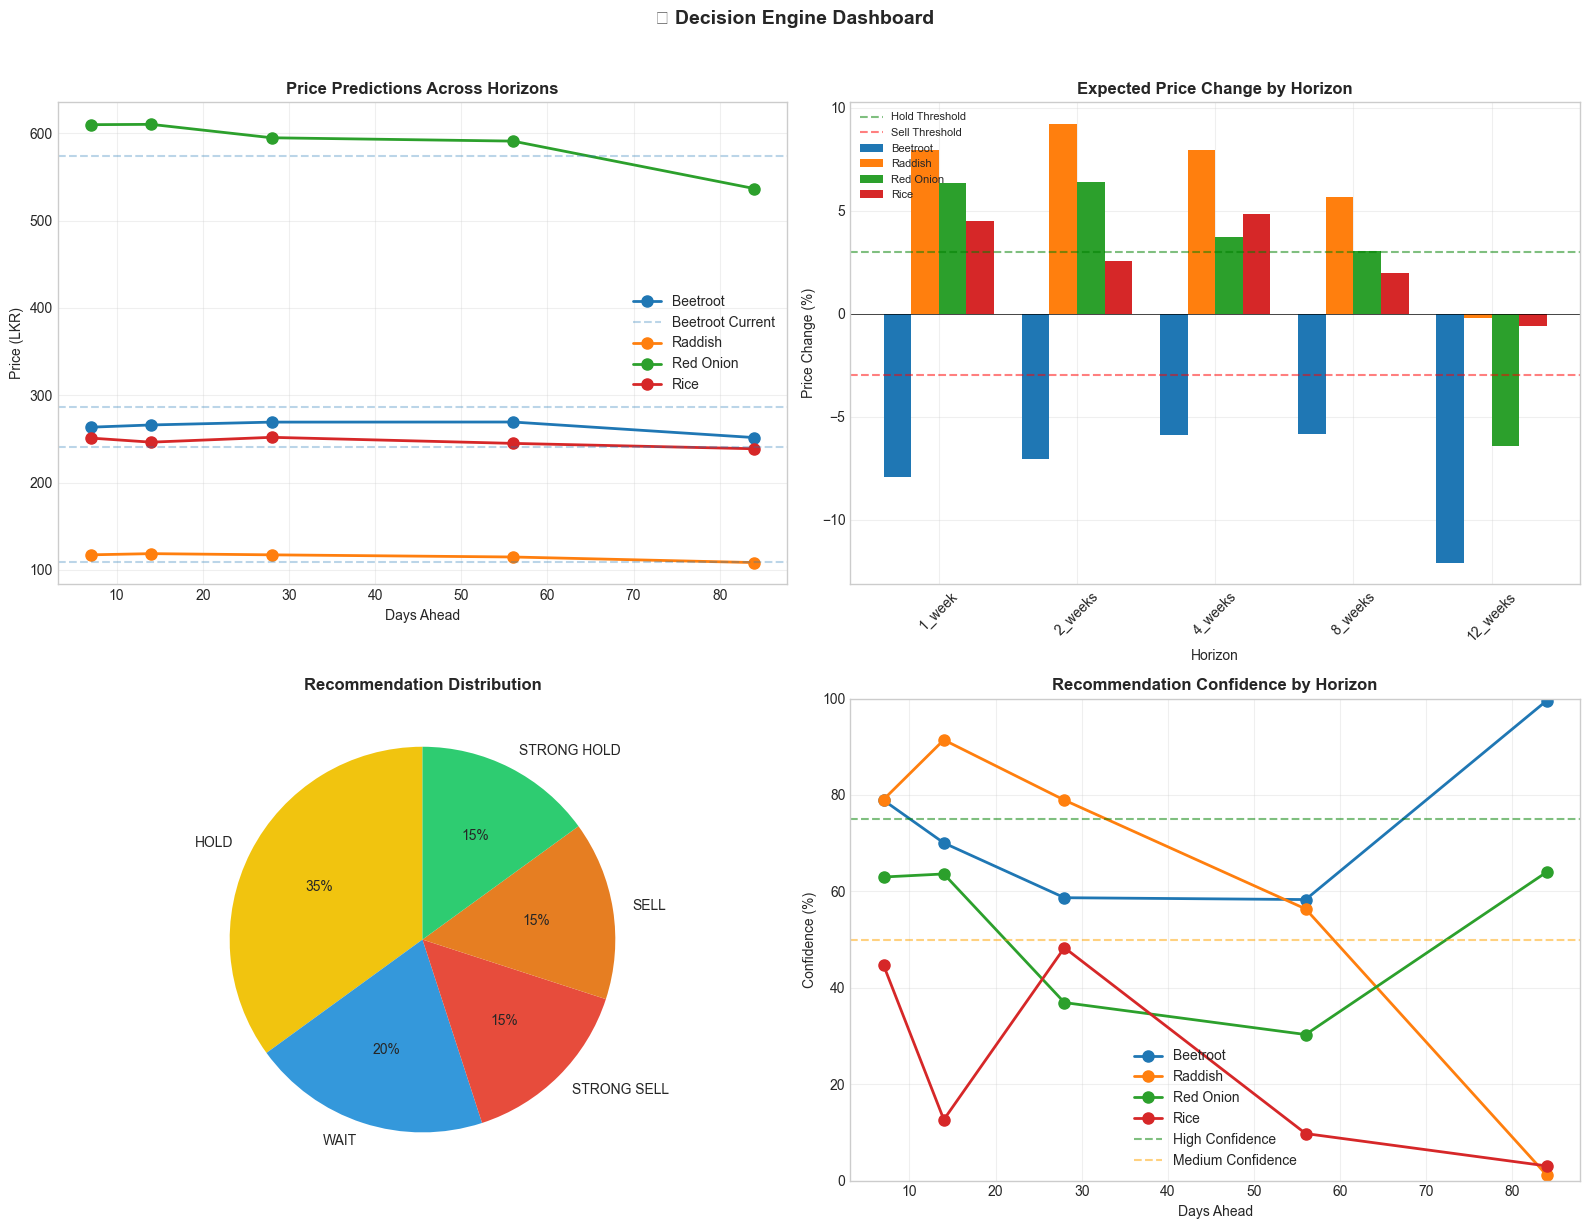

In [28]:
# Create a visual dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

crops = rec_df['Crop'].unique()
colors = {'STRONG SELL': '#e74c3c', 'SELL': '#e67e22', 'WAIT': '#3498db', 
          'HOLD': '#f1c40f', 'STRONG HOLD': '#2ecc71'}

# 1. Price Predictions by Horizon
ax1 = axes[0, 0]
for crop in crops:
    crop_rec = rec_df[rec_df['Crop'] == crop]
    ax1.plot(crop_rec['Days'], crop_rec['Predicted_Price'], 'o-', 
             label=crop, linewidth=2, markersize=8)
    # Add current price as starting point
    ax1.axhline(y=crop_rec['Current_Price'].iloc[0], linestyle='--', 
                alpha=0.3, label=f'{crop} Current' if crop == crops[0] else '')

ax1.set_xlabel('Days Ahead')
ax1.set_ylabel('Price (LKR)')
ax1.set_title('Price Predictions Across Horizons', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Price Change Percentage
ax2 = axes[0, 1]
x = np.arange(len(HORIZONS))
width = 0.2
for i, crop in enumerate(crops):
    crop_rec = rec_df[rec_df['Crop'] == crop]
    ax2.bar(x + i*width, crop_rec['Change_Percent'], width, label=crop)

ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.axhline(y=DECISION_CONFIG['hold_threshold'], color='green', linestyle='--', alpha=0.5, label='Hold Threshold')
ax2.axhline(y=DECISION_CONFIG['sell_threshold'], color='red', linestyle='--', alpha=0.5, label='Sell Threshold')
ax2.set_xlabel('Horizon')
ax2.set_ylabel('Price Change (%)')
ax2.set_title('Expected Price Change by Horizon', fontsize=12, fontweight='bold')
ax2.set_xticks(x + width * (len(crops)-1) / 2)
ax2.set_xticklabels(list(HORIZONS.keys()), rotation=45)
ax2.legend(loc='upper left', fontsize=8)
ax2.grid(True, alpha=0.3)

# 3. Recommendation Distribution
ax3 = axes[1, 0]
rec_counts = rec_df['Recommendation'].value_counts()
rec_colors = [colors.get(r, 'gray') for r in rec_counts.index]
ax3.pie(rec_counts.values, labels=rec_counts.index, colors=rec_colors,
        autopct='%1.0f%%', startangle=90)
ax3.set_title('Recommendation Distribution', fontsize=12, fontweight='bold')

# 4. Confidence Scores
ax4 = axes[1, 1]
for crop in crops:
    crop_rec = rec_df[rec_df['Crop'] == crop]
    ax4.plot(crop_rec['Days'], crop_rec['Confidence'] * 100, 'o-', 
             label=crop, linewidth=2, markersize=8)

ax4.axhline(y=DECISION_CONFIG['high_confidence']*100, color='green', 
            linestyle='--', alpha=0.5, label='High Confidence')
ax4.axhline(y=DECISION_CONFIG['medium_confidence']*100, color='orange', 
            linestyle='--', alpha=0.5, label='Medium Confidence')
ax4.set_xlabel('Days Ahead')
ax4.set_ylabel('Confidence (%)')
ax4.set_title('Recommendation Confidence by Horizon', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 100)

plt.suptitle('🚦 Decision Engine Dashboard', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Alert System

In [29]:
def generate_alerts(rec_df):
    """
    Generate actionable alerts based on recommendations.
    """
    alerts = []
    
    for crop in rec_df['Crop'].unique():
        crop_rec = rec_df[rec_df['Crop'] == crop]
        
        # Check for significant price movements
        for _, row in crop_rec.iterrows():
            change = row['Change_Percent']
            
            if change <= -10:
                alerts.append({
                    'Priority': '🔴 URGENT',
                    'Crop': crop,
                    'Horizon': row['Horizon'],
                    'Alert': f"Major price DROP expected: {change:.1f}%",
                    'Action': 'SELL IMMEDIATELY',
                    'Confidence': row['Confidence']
                })
            elif change >= 10:
                alerts.append({
                    'Priority': '🟢 OPPORTUNITY',
                    'Crop': crop,
                    'Horizon': row['Horizon'],
                    'Alert': f"Major price RISE expected: +{change:.1f}%",
                    'Action': 'HOLD FOR BETTER PRICE',
                    'Confidence': row['Confidence']
                })
            elif abs(change) >= 5 and row['Confidence'] > 0.6:
                alerts.append({
                    'Priority': '🟡 ATTENTION',
                    'Crop': crop,
                    'Horizon': row['Horizon'],
                    'Alert': f"Price movement expected: {change:+.1f}%",
                    'Action': row['Recommendation'],
                    'Confidence': row['Confidence']
                })
        
        # Check for trend reversals
        changes = crop_rec['Change_Percent'].values
        if len(changes) >= 2:
            if changes[0] * changes[-1] < 0:  # Sign change
                alerts.append({
                    'Priority': '🔵 INFO',
                    'Crop': crop,
                    'Horizon': 'Multiple',
                    'Alert': 'Trend reversal detected across horizons',
                    'Action': 'Monitor closely',
                    'Confidence': np.mean(crop_rec['Confidence'])
                })
    
    return pd.DataFrame(alerts)

# Generate alerts
alerts_df = generate_alerts(rec_df)

print("ACTIVE ALERTS")

if len(alerts_df) > 0:
    for _, alert in alerts_df.iterrows():
        print(f"\n{alert['Priority']} - {alert['Crop']}")
        print(f"  Horizon: {alert['Horizon']}")
        print(f"  Alert: {alert['Alert']}")
        print(f"  Action: {alert['Action']}")
        print(f"  Confidence: {alert['Confidence']*100:.0f}%")
else:
    print("\n✅ No significant alerts at this time.")

ACTIVE ALERTS

🟡 ATTENTION - Beetroot
  Horizon: 1_week
  Alert: Price movement expected: -7.9%
  Action: STRONG SELL
  Confidence: 79%

🟡 ATTENTION - Beetroot
  Horizon: 2_weeks
  Alert: Price movement expected: -7.0%
  Action: STRONG SELL
  Confidence: 70%

🔴 URGENT - Beetroot
  Horizon: 12_weeks
  Alert: Major price DROP expected: -12.1%
  Action: SELL IMMEDIATELY
  Confidence: 100%

🟡 ATTENTION - Raddish
  Horizon: 1_week
  Alert: Price movement expected: +7.9%
  Action: STRONG HOLD
  Confidence: 79%

🟡 ATTENTION - Raddish
  Horizon: 2_weeks
  Alert: Price movement expected: +9.2%
  Action: STRONG HOLD
  Confidence: 91%

🟡 ATTENTION - Raddish
  Horizon: 4_weeks
  Alert: Price movement expected: +7.9%
  Action: STRONG HOLD
  Confidence: 79%

🔵 INFO - Raddish
  Horizon: Multiple
  Alert: Trend reversal detected across horizons
  Action: Monitor closely
  Confidence: 61%

🟡 ATTENTION - Red Onion
  Horizon: 1_week
  Alert: Price movement expected: +6.3%
  Action: HOLD
  Confidence: 63%

---
## Best Time to Sell Analysis

In [30]:
def find_best_selling_time(rec_df):
    """
    Analyze predictions to find optimal selling time for each crop.
    """
    results = []
    
    for crop in rec_df['Crop'].unique():
        crop_rec = rec_df[rec_df['Crop'] == crop].copy()
        
        # Find horizon with highest predicted price
        best_idx = crop_rec['Predicted_Price'].idxmax()
        best_row = crop_rec.loc[best_idx]
        
        current_price = best_row['Current_Price']
        best_price = best_row['Predicted_Price']
        best_horizon = best_row['Horizon']
        best_days = best_row['Days']
        
        # Calculate potential gain
        potential_gain = ((best_price - current_price) / current_price) * 100
        
        # Determine recommendation
        if potential_gain > 3:
            suggestion = f"WAIT {best_days} days for {potential_gain:.1f}% higher price"
        elif potential_gain < -3:
            suggestion = f"SELL NOW - prices expected to drop"
        else:
            suggestion = f"Flexible timing - prices stable"
        
        results.append({
            'Crop': crop,
            'Current_Price': current_price,
            'Best_Price': best_price,
            'Best_Horizon': best_horizon,
            'Days_to_Wait': best_days,
            'Potential_Gain_%': potential_gain,
            'Suggestion': suggestion
        })
    
    return pd.DataFrame(results)

# Find best selling times
best_times = find_best_selling_time(rec_df)

print("OPTIMAL SELLING TIME ANALYSIS")

for _, row in best_times.iterrows():
    print(f"\n{row['Crop']}:")
    print(f"  Current Price: {row['Current_Price']:.2f} LKR")
    print(f"  Best Price: {row['Best_Price']:.2f} LKR (in {row['Days_to_Wait']} days)")
    print(f"  Potential Gain: {row['Potential_Gain_%']:+.1f}%")
    print(f"  {row['Suggestion']}")

OPTIMAL SELLING TIME ANALYSIS

Beetroot:
  Current Price: 286.07 LKR
  Best Price: 269.32 LKR (in 56 days)
  Potential Gain: -5.9%
  SELL NOW - prices expected to drop

Raddish:
  Current Price: 108.63 LKR
  Best Price: 118.61 LKR (in 14 days)
  Potential Gain: +9.2%
  WAIT 14 days for 9.2% higher price

Red Onion:
  Current Price: 573.50 LKR
  Best Price: 610.13 LKR (in 14 days)
  Potential Gain: +6.4%
  WAIT 14 days for 6.4% higher price

Rice:
  Current Price: 240.16 LKR
  Best Price: 251.80 LKR (in 28 days)
  Potential Gain: +4.8%
  WAIT 28 days for 4.8% higher price


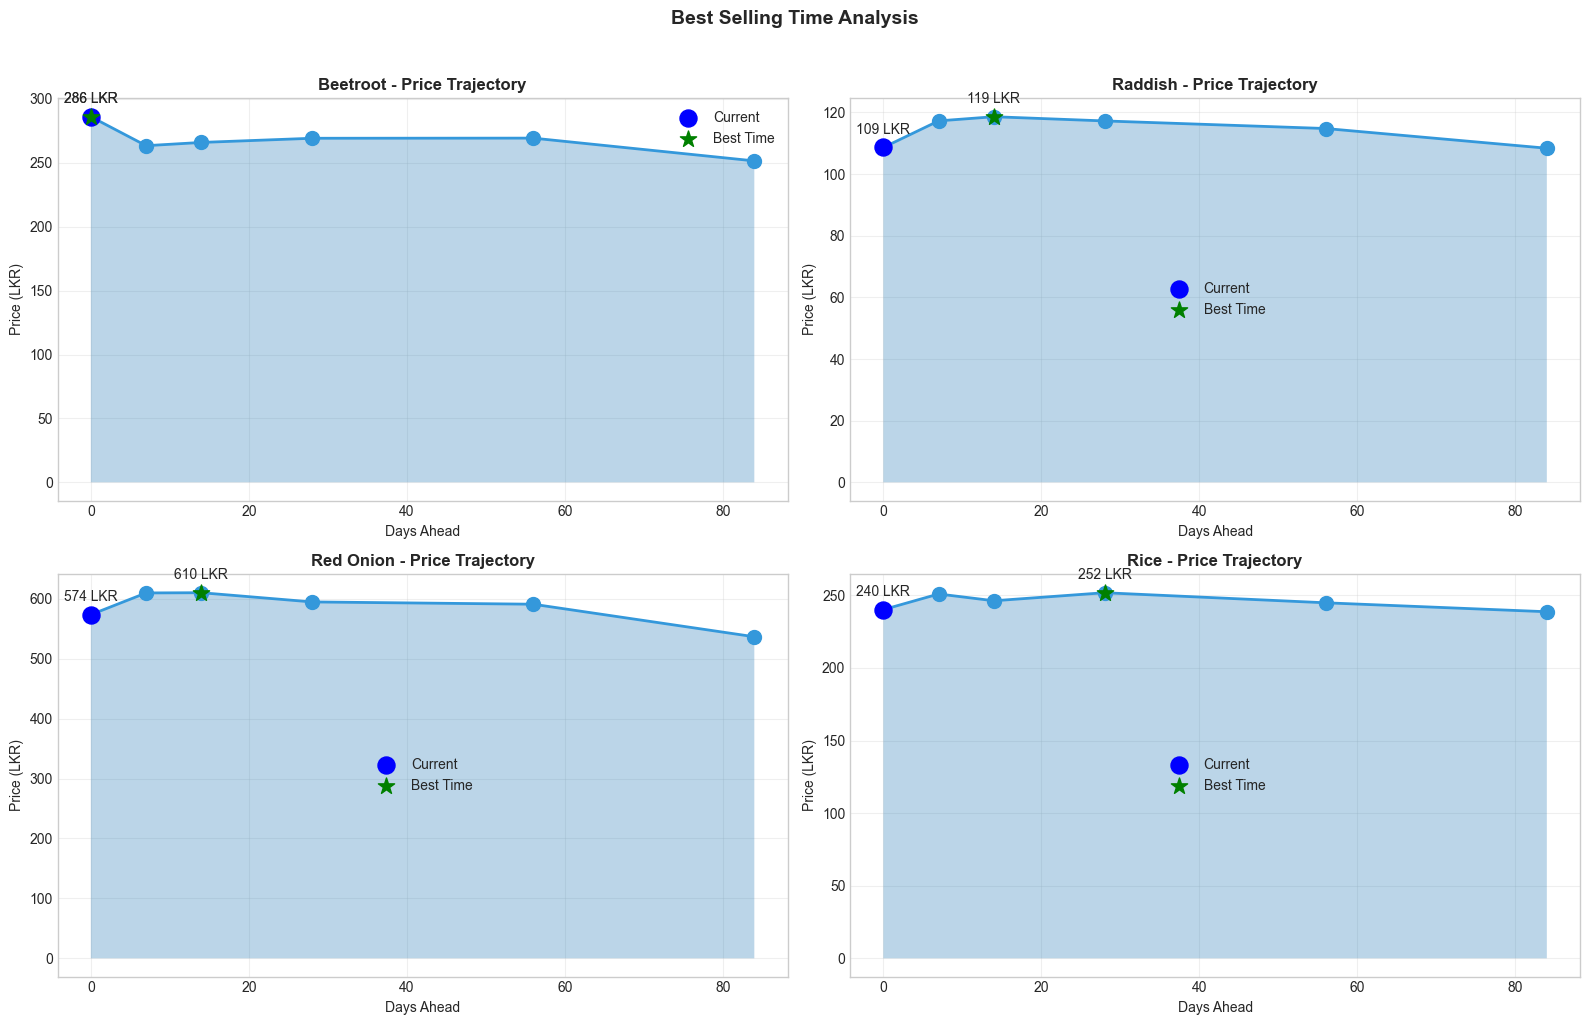

In [31]:
# Visualize best selling times
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for idx, crop in enumerate(crops[:4]):
    ax = axes[idx // 2, idx % 2]
    crop_rec = rec_df[rec_df['Crop'] == crop]
    
    # Plot price trajectory
    days = [0] + list(crop_rec['Days'])
    prices = [crop_rec['Current_Price'].iloc[0]] + list(crop_rec['Predicted_Price'])
    
    # Color based on recommendation
    ax.plot(days, prices, 'o-', linewidth=2, markersize=10, color='#3498db')
    ax.fill_between(days, prices, alpha=0.3)
    
    # Mark current and best price
    best_idx = np.argmax(prices)
    ax.scatter([0], [prices[0]], color='blue', s=150, zorder=5, label='Current')
    ax.scatter([days[best_idx]], [prices[best_idx]], color='green', s=150, 
               zorder=5, marker='*', label='Best Time')
    
    # Add annotations
    ax.annotate(f'{prices[0]:.0f} LKR', (0, prices[0]), 
                textcoords="offset points", xytext=(0,10), ha='center')
    ax.annotate(f'{prices[best_idx]:.0f} LKR', (days[best_idx], prices[best_idx]), 
                textcoords="offset points", xytext=(0,10), ha='center')
    
    ax.set_xlabel('Days Ahead')
    ax.set_ylabel('Price (LKR)')
    ax.set_title(f'{crop} - Price Trajectory', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Best Selling Time Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## Risk Assessment

In [32]:
def assess_risk(rec_df, agg_df):
    """
    Assess risk level for each crop based on volatility and prediction uncertainty.
    """
    risk_assessment = []
    
    for crop in rec_df['Crop'].unique():
        crop_rec = rec_df[rec_df['Crop'] == crop]
        crop_hist = agg_df[agg_df['item'] == crop]
        
        # Calculate historical volatility
        price_std = crop_hist['price'].std()
        price_mean = crop_hist['price'].mean()
        volatility = (price_std / price_mean) * 100
        
        # Prediction uncertainty (spread of predictions)
        pred_range = crop_rec['Predicted_Price'].max() - crop_rec['Predicted_Price'].min()
        pred_uncertainty = (pred_range / crop_rec['Current_Price'].iloc[0]) * 100
        
        # Average confidence
        avg_confidence = crop_rec['Confidence'].mean()
        
        # Calculate risk score (0-100)
        risk_score = (volatility * 0.4 + pred_uncertainty * 0.4 + (1 - avg_confidence) * 100 * 0.2)
        risk_score = min(risk_score, 100)
        
        # Determine risk level
        if risk_score < 30:
            risk_level = '🟢 LOW'
        elif risk_score < 60:
            risk_level = '🟡 MEDIUM'
        else:
            risk_level = '🔴 HIGH'
        
        risk_assessment.append({
            'Crop': crop,
            'Volatility_%': volatility,
            'Prediction_Uncertainty_%': pred_uncertainty,
            'Avg_Confidence': avg_confidence,
            'Risk_Score': risk_score,
            'Risk_Level': risk_level
        })
    
    return pd.DataFrame(risk_assessment)

# Assess risks
risk_df = assess_risk(rec_df, agg_df)

print("\n" + "="*80)
print("RISK ASSESSMENT")
print("="*80)

for _, row in risk_df.iterrows():
    print(f"\n{row['Crop']}:")
    print(f"  Historical Volatility: {row['Volatility_%']:.1f}%")
    print(f"  Prediction Uncertainty: {row['Prediction_Uncertainty_%']:.1f}%")
    print(f"  Average Confidence: {row['Avg_Confidence']*100:.0f}%")
    print(f"  Risk Score: {row['Risk_Score']:.0f}/100")
    print(f"  Risk Level: {row['Risk_Level']}")


RISK ASSESSMENT

Beetroot:
  Historical Volatility: 15.8%
  Prediction Uncertainty: 6.2%
  Average Confidence: 73%
  Risk Score: 14/100
  Risk Level: 🟢 LOW

Raddish:
  Historical Volatility: 15.9%
  Prediction Uncertainty: 9.4%
  Average Confidence: 61%
  Risk Score: 18/100
  Risk Level: 🟢 LOW

Red Onion:
  Historical Volatility: 15.9%
  Prediction Uncertainty: 12.8%
  Average Confidence: 52%
  Risk Score: 21/100
  Risk Level: 🟢 LOW

Rice:
  Historical Volatility: 15.8%
  Prediction Uncertainty: 5.5%
  Average Confidence: 24%
  Risk Score: 24/100
  Risk Level: 🟢 LOW


---
## Executive Summary Report

In [33]:
def generate_executive_summary(rec_df, best_times, risk_df, alerts_df):
   
    
    for _, row in best_times.iterrows():
        emoji = '🟢' if row['Potential_Gain_%'] > 3 else ('🔴' if row['Potential_Gain_%'] < -3 else '🟡')
        print(f"\n{emoji} {row['Crop']}:")
        print(f"   {row['Suggestion']}")
        print(f"   Current: {row['Current_Price']:.0f} LKR → Best: {row['Best_Price']:.0f} LKR")
    
    print("\n" + "-"*40)
    print("RISK OVERVIEW")
    print("-"*40)
    
    for _, row in risk_df.iterrows():
        print(f"  {row['Risk_Level']} {row['Crop']}: Score {row['Risk_Score']:.0f}/100")
    
    print("\n" + "-"*40)
    print("ACTIVE ALERTS")
    print("-"*40)
    
    urgent_alerts = alerts_df[alerts_df['Priority'].str.contains('URGENT|OPPORTUNITY')]
    if len(urgent_alerts) > 0:
        for _, alert in urgent_alerts.iterrows():
            print(f"  {alert['Priority']}: {alert['Crop']} - {alert['Alert']}")
    else:
        print("No urgent alerts")
    
    print("\n" + "="*80)

# Generate summary
generate_executive_summary(rec_df, best_times, risk_df, alerts_df)


🔴 Beetroot:
   SELL NOW - prices expected to drop
   Current: 286 LKR → Best: 269 LKR

🟢 Raddish:
   WAIT 14 days for 9.2% higher price
   Current: 109 LKR → Best: 119 LKR

🟢 Red Onion:
   WAIT 14 days for 6.4% higher price
   Current: 574 LKR → Best: 610 LKR

🟢 Rice:
   WAIT 28 days for 4.8% higher price
   Current: 240 LKR → Best: 252 LKR

----------------------------------------
RISK OVERVIEW
----------------------------------------
  🟢 LOW Beetroot: Score 14/100
  🟢 LOW Raddish: Score 18/100
  🟢 LOW Red Onion: Score 21/100
  🟢 LOW Rice: Score 24/100

----------------------------------------
ACTIVE ALERTS
----------------------------------------
  🔴 URGENT: Beetroot - Major price DROP expected: -12.1%



---
## Save Results

In [34]:
import os

# Create directory for decision engine outputs
save_dir = '../models/saved_models/decision_engine'
os.makedirs(save_dir, exist_ok=True)

# Save recommendations
rec_df.to_csv(f'{save_dir}/recommendations.csv', index=False)

# Save best selling times
best_times.to_csv(f'{save_dir}/best_selling_times.csv', index=False)

# Save risk assessment
risk_df.to_csv(f'{save_dir}/risk_assessment.csv', index=False)

# Save alerts
if len(alerts_df) > 0:
    alerts_df.to_csv(f'{save_dir}/alerts.csv', index=False)

# Save decision configuration
joblib.dump(DECISION_CONFIG, f'{save_dir}/decision_config.joblib')


['../models/saved_models/decision_engine/decision_config.joblib']